In [2]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rasterio
import numpy as np
from scipy.stats import norm

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

# Add the path to the custom library
custom_library_path = os.path.abspath('util/processing/')
sys.path.append(custom_library_path)

import extraction_squares, time_series

if operating_system == 'curnagl':
    name_of_variable= pd.read_csv('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS/variable_list_80_mean.csv')
    path_data = '/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS'
else:
    name_of_variable= pd.read_csv('data/variable_list_levels.csv')
    path_data = 'data'

storm_dates = pd.read_csv('pre_processing/tracks/storm_dates.csv')
path_tracks_1h = 'pre_processing/tracks/ALL_TRACKS/tracks_1h'
#path_tracks_1h_non_EU = 'pre_processing/tracks/ALL_TRACKS/tracks_1h_non_EU'
dataset = 'datasets_1h'
#dataset_non_EU = 'datasets_1h_non_EU'

# open cluster data

data = pd.read_csv('pre_processing/cluster/number_of_clusters/cluster_14.csv')

In [3]:
path = '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/'
cluster_14 = pd.read_csv(f'{path}pre_processing/cluster/number_of_clusters/cluster_14.csv')

test_pd = time_series.tif_to_dataframe(f'{path}data/timeseries_rasters_storms/5_VIVIAN.tif', '2_25')
test_pd_climato = time_series.tif_to_dataframe(f'{path}data/climatology/instantaneous_10m_wind_gust_cut/max_winds_europe_2_25_cut.tif', '2_25')

# Define latitude and longitude boundaries for Eastern and Southern Europe
lat_min, lat_max = 35, 75
lon_min, lon_max = -10, 25

# Filter the DataFrame based on these boundaries
df_filtered_small = test_pd[(test_pd['latitude'] >= lat_min) & (test_pd['latitude'] <= lat_max) &
                 (test_pd['longitude'] >= lon_min) & (test_pd['longitude'] <= lon_max)]
df_filtered_small_climato = test_pd_climato[(test_pd_climato['latitude'] >= lat_min) & (test_pd_climato['latitude'] <= lat_max) &
                    (test_pd_climato['longitude'] >= lon_min) & (test_pd_climato['longitude'] <= lon_max)]

# remove the rows with no data
df_filtered_small = df_filtered_small.dropna()
df_filtered_small_climato = df_filtered_small_climato.dropna()

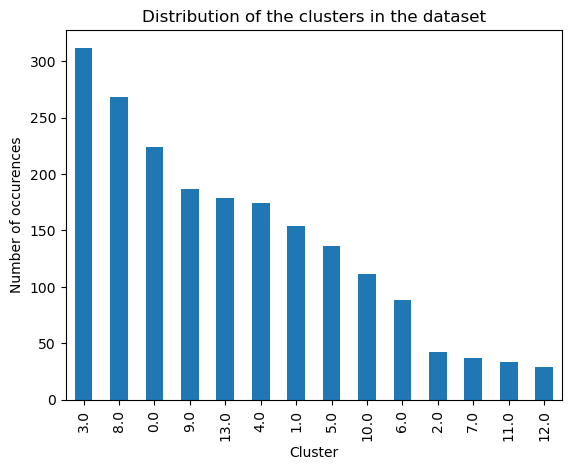

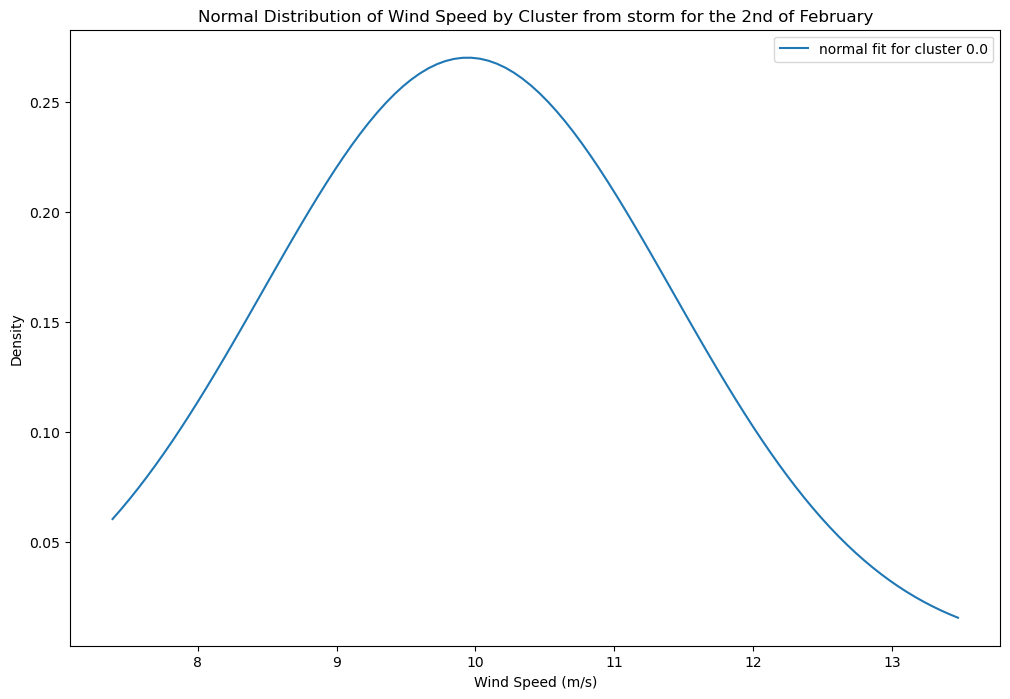

In [18]:
# add the column cluster to df_filtered_small

df_filtered_small['cluster'] = cluster_14['cluster']
df_filtered_small_climato['cluster'] = cluster_14['cluster']

# create a distribution per cluster on the dataframe
df_filtered_small['cluster'].value_counts().plot(kind='bar')
plt.title('Distribution of the clusters in the dataset')
plt.xlabel('Cluster')
plt.ylabel('Number of occurences')
plt.show()

# See the disctubtion of wind gusts per cluster

# Group data by cluster
clusters_climato = df_filtered_small_climato.groupby('cluster')
clusters_vivian = df_filtered_small.groupby('cluster')

# Plot normal distribution for each cluster
plt.figure(figsize=(12, 8))

for cluster, group in clusters_climato:
    # Extract wind_speed_2_25 values for the cluster
    wind_speeds = group['wind_speed_2_25']
    
    # Plot histogram
    #sns.histplot(wind_speeds, kde=False, stat="density", label=f'Cluster {cluster}', bins=30, alpha=0.5)
    
    # Fit and plot a normal distribution
    mean, std = norm.fit(wind_speeds)
    x = np.linspace(wind_speeds.min(), wind_speeds.max(), 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=f'normal fit for cluster {cluster}')
    break

# Add labels and legend
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Density')
plt.title('Normal Distribution of Wind Speed by Cluster from storm for the 2nd of February')
plt.legend()
plt.show()

In [21]:
# pick the max speed value within every cluster

max_speeds = clusters_vivian['wind_speed_2_25'].median()
print(max_speeds)

cluster
0.0     11.605776
1.0     14.267298
2.0     15.277231
3.0     14.169900
4.0     11.920962
5.0     14.725447
6.0     11.339498
7.0     13.522808
8.0     14.316207
9.0     14.619688
10.0    13.458433
11.0    14.242635
12.0    14.626376
13.0    13.613936
Name: wind_speed_2_25, dtype: float64


In [17]:
# extract the max speed percentile for each cluster

# Calculate the percentile
'''for cluster, group in clusters:
    # Extract wind_speed_2_25 values for the cluster
    wind_speeds = group['wind_speed_2_25']
    max_speeds = wind_speeds.max()
    percentile = np.sum(np.array(wind_speeds) <= max_speeds) / len(wind_speeds) * 100'''

cluster_0 = max_speeds[0]
# Get the first group's key
first_key = next(iter(clusters_climato.groups.keys()))

# Extract the first group's DataFrame
first_group = clusters_climato.get_group(first_key)

CDF_cluster_0 = first_group['wind_speed_2_25']

percentile = np.sum(np.array(CDF_cluster_0) <= cluster_0) / len(CDF_cluster_0) * 100

print(f"The percentile of the value {cluster_0} is {percentile}%")

The percentile of the value 16.703926991148855 is 100.0%
